# Aggregating traffic from pairs of IPs

In [76]:
import pandas as pd
from pprint import pprint
df = pd.read_json("./data/pairs_data.json")
print(df.columns)

hits = df['hits']['hits']
pprint(hits[:10])

Index(['took', 'timed_out', '_shards', 'hits', 'aggregations'], dtype='object')
[]


In [77]:
def pair_features(df):
    # Extract the buckets from the aggregation
    buckets = df['aggregations']['flow_features']['buckets']
    
    # Convert buckets to a list of dictionaries for DataFrame
    rows = []
    for bucket in buckets:
        row = {
            'src_ip': bucket['key']['src_ip'],
            'dest_ip': bucket['key']['dest_ip'],
            'flow_count': bucket['doc_count'],
            'total_bytes_sent': bucket['total_bytes_sent']['value'],
            'total_bytes_received': bucket['total_bytes_received']['value'],
            'total_packets_sent': bucket['total_packets_sent']['value'],
            'total_packets_received': bucket['total_packets_received']['value'],
            'connection_count': bucket['connection_count']['value'],
            'avg_flow_duration': bucket['avg_flow_duration']['value'],
            'unique_ports': bucket['unique_ports']['value']
        }
        rows.append(row)
    
    # Create DataFrame
    ip_pairs_df = pd.DataFrame(rows)
    
    # Display basic information about the DataFrame
    # print(f"Shape: {ip_pairs_df.shape}")
    # print(f"\nColumns: {ip_pairs_df.columns.tolist()}")
    # print(f"\nFirst 5 rows:")
    # print(ip_pairs_df.head())
    
    # Calculate some derived features
    ip_pairs_df['total_bytes'] = ip_pairs_df['total_bytes_sent'] + ip_pairs_df['total_bytes_received']
    ip_pairs_df['total_packets'] = ip_pairs_df['total_packets_sent'] + ip_pairs_df['total_packets_received']
    ip_pairs_df['bytes_ratio'] = ip_pairs_df['total_bytes_sent'] / (ip_pairs_df['total_bytes_received'] + 1)  # +1 to avoid division by zero
    ip_pairs_df['packets_ratio'] = ip_pairs_df['total_packets_sent'] / (ip_pairs_df['total_packets_received'] + 1)
    
    return ip_pairs_df

In [78]:


# Convert aggregated IP pairs data to pandas DataFrame
import pandas as pd

# Assuming you have the aggregation response in a variable called 'response' or loaded from JSON
# Replace this with your actual data loading method
flow1 = pd.read_json("./data/pairs_data.json")
flow2 = pd.read_json("./data/pairs_data2.json")
X = pair_features(flow1)
Y = pair_features(flow2)


In [79]:
# Optional: Add statistical summaries and visualizations
print("\nStatistical Summary:")
#print(X.describe())
print(X.head())

# Save to CSV if needed
# ip_pairs_df.to_csv('aggregated_ip_pairs.csv', index=False)


Statistical Summary:
  src_ip            dest_ip  flow_count  total_bytes_sent  \
0     ::            ff02::1         402          100080.0   
1     ::            ff02::2         292           27690.0   
2     ::           ff02::16          98           27830.0   
3     ::           ff02::fb           1             172.0   
4     ::  ff02::1:ff03:c448           7            1092.0   

   total_bytes_received  total_packets_sent  total_packets_received  \
0                   0.0              1112.0                     0.0   
1                   0.0               327.0                     0.0   
2                   0.0               293.0                     0.0   
3                   0.0                 2.0                     0.0   
4                   0.0                14.0                     0.0   

   connection_count  avg_flow_duration  unique_ports  total_bytes  \
0               402           0.584577             0     100080.0   
1               292           1.243151        

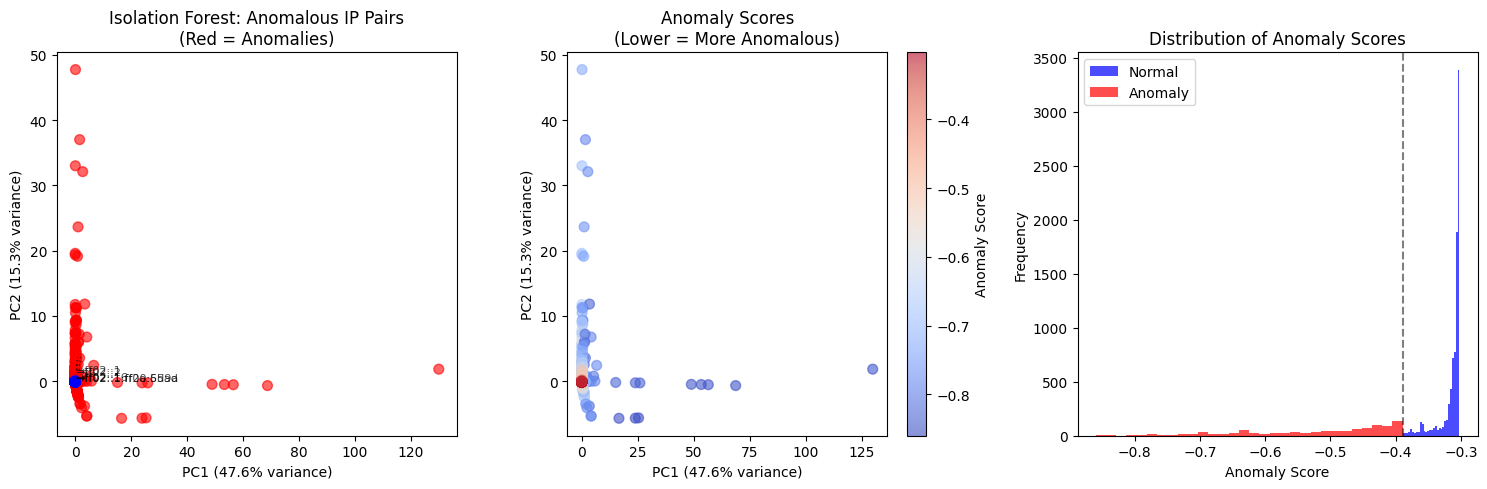

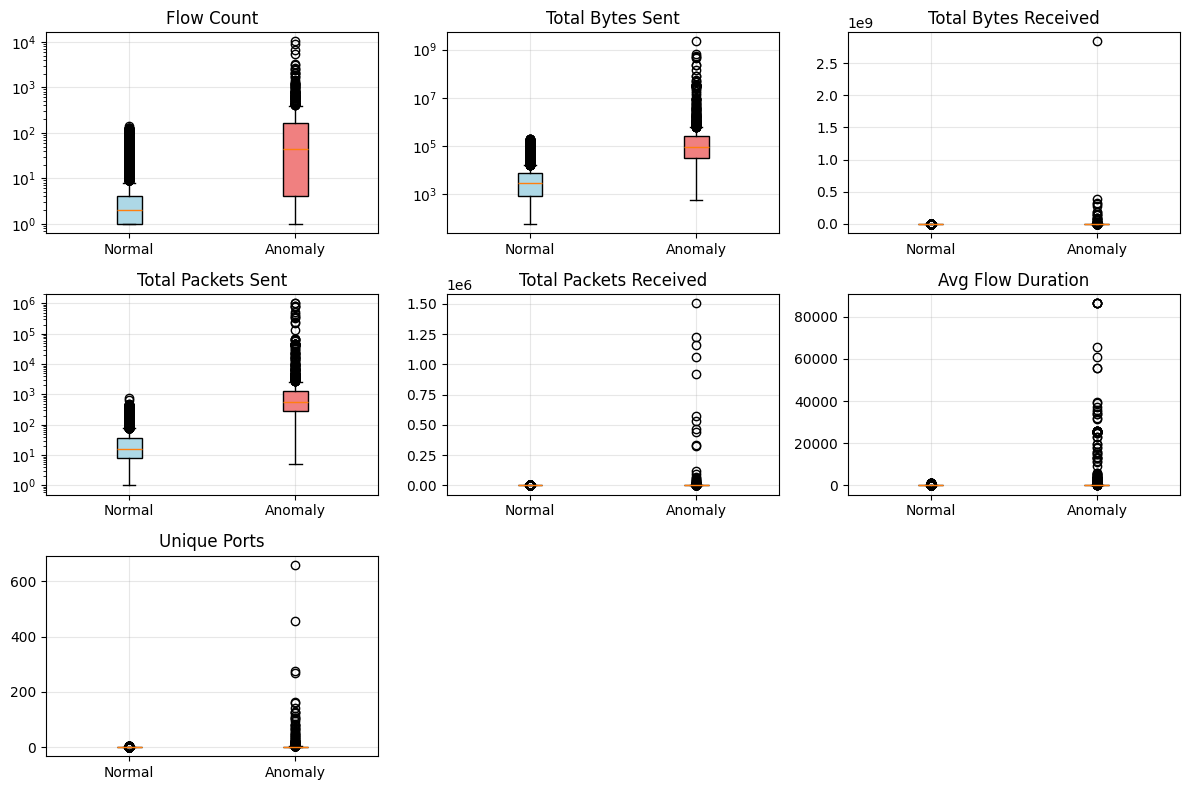

Top 10 Most Anomalous IP Pairs:
   4.153.215.61 → 172.16.1.57     | Flows:    2 | Bytes: 180,883,039 | Ports:  2 | Score: -0.860
   4.153.215.61 → 172.16.1.60     | Flows:    1 | Bytes: 172,750,817 | Ports:  1 | Score: -0.858
        1.1.1.1 → 192.168.1.4     | Flows:    1 | Bytes: 40,220,512 | Ports:  0 | Score: -0.853
     10.1.1.107 → 38.73.225.107   | Flows:   94 | Bytes: 1,041,732,587 | Ports:  1 | Score: -0.850
      10.2.1.15 → 141.193.192.13  | Flows:  198 | Bytes: 5,035,312,418 | Ports:  1 | Score: -0.848
     10.1.1.107 → 38.73.225.102   | Flows:   84 | Bytes: 806,677,490 | Ports:  1 | Score: -0.845
     10.1.1.107 → 38.73.225.104   | Flows:   86 | Bytes: 855,706,826 | Ports:  1 | Score: -0.845
     10.1.1.107 → 38.73.225.103   | Flows:   76 | Bytes: 740,424,367 | Ports:  1 | Score: -0.843
     10.1.1.107 → 38.73.225.106   | Flows:   55 | Bytes: 395,623,141 | Ports:  1 | Score: -0.832
     10.1.1.107 → 38.73.225.100   | Flows:   54 | Bytes: 363,709,750 | Ports:  1 | Score: -0

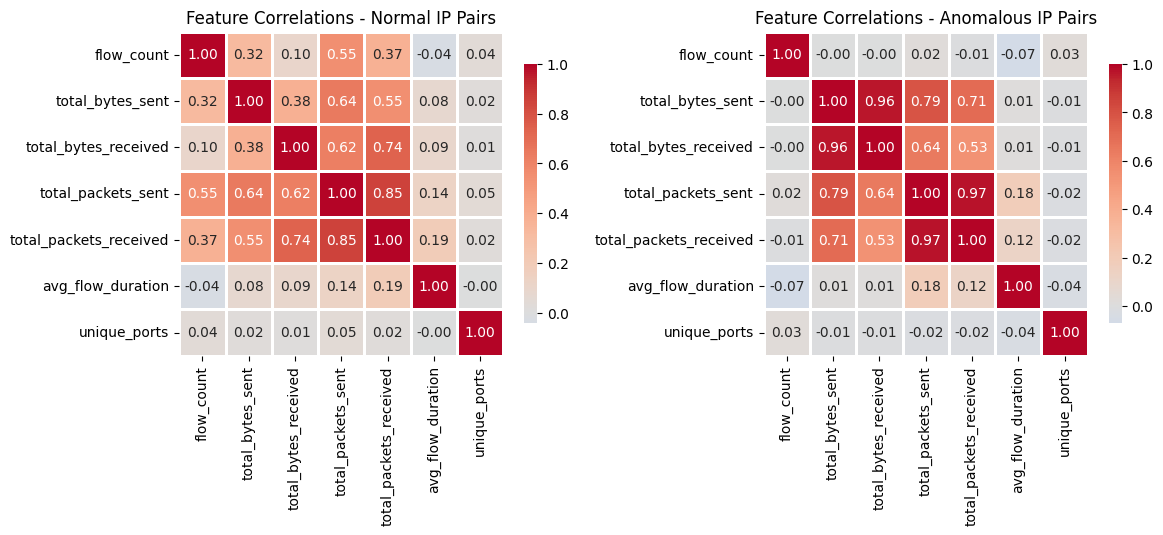


Summary Statistics:
Total IP pairs: 10000
Anomalous pairs: 1000 (10.0%)
Normal pairs: 9000 (90.0%)


In [80]:
# Isolation Forest Visualization for Aggregated IP Pairs
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use X dataframe (from flow1) for visualization
ip_pairs_df = X  # Use the X dataframe that was created earlier

# Select features for anomaly detection
feature_cols = ['flow_count', 'total_bytes_sent', 'total_bytes_received', 
                'total_packets_sent', 'total_packets_received', 
                'avg_flow_duration', 'unique_ports']

# Scale features for better visualization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(ip_pairs_df[feature_cols])

# 1. Train Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
predictions = iso_forest.fit_predict(scaled_features)
anomaly_scores = iso_forest.score_samples(scaled_features)

# Add predictions to dataframe
ip_pairs_df['anomaly'] = predictions
ip_pairs_df['anomaly_score'] = anomaly_scores

# 2. Create PCA for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(scaled_features)

# Visualize with PCA (2D)
plt.figure(figsize=(15, 5))

# Plot 1: Anomalies highlighted
plt.subplot(1, 3, 1)
colors = ['blue' if x == 1 else 'red' for x in predictions]
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=colors, alpha=0.6, s=50)
plt.title('Isolation Forest: Anomalous IP Pairs\n(Red = Anomalies)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')

# Add annotations for anomalies
anomaly_indices = np.where(predictions == -1)[0]
for idx in anomaly_indices[:5]:  # Show first 5 anomalies
    plt.annotate(f"{ip_pairs_df.iloc[idx]['src_ip']}\n→{ip_pairs_df.iloc[idx]['dest_ip']}", 
                (features_pca[idx, 0], features_pca[idx, 1]),
                fontsize=8, alpha=0.7)

# Plot 2: Anomaly scores heatmap
plt.subplot(1, 3, 2)
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], 
                     c=anomaly_scores, cmap='coolwarm', alpha=0.6, s=50)
plt.colorbar(scatter, label='Anomaly Score')
plt.title('Anomaly Scores\n(Lower = More Anomalous)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')

# Plot 3: Score distribution
plt.subplot(1, 3, 3)
plt.hist(anomaly_scores[predictions == 1], bins=30, alpha=0.7, label='Normal', color='blue')
plt.hist(anomaly_scores[predictions == -1], bins=30, alpha=0.7, label='Anomaly', color='red')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.axvline(x=np.percentile(anomaly_scores, 10), color='black', linestyle='--', alpha=0.5, label='Threshold')

plt.tight_layout()
plt.show()

# 3. Feature comparison between normal and anomalous IP pairs
anomaly_mask = predictions == -1
normal_mask = predictions == 1

plt.figure(figsize=(12, 8))

# Create subplots for each feature
for i, col in enumerate(feature_cols):
    plt.subplot(3, 3, i+1)
    
    # Box plot with updated parameter name for Matplotlib 3.9+
    data_to_plot = [ip_pairs_df[normal_mask][col], ip_pairs_df[anomaly_mask][col]]
    bp = plt.boxplot(data_to_plot, tick_labels=['Normal', 'Anomaly'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    plt.title(col.replace('_', ' ').title())
    # Fix divide by zero warning
    col_min = ip_pairs_df[col].min()
    col_max = ip_pairs_df[col].max()
    if col_min > 0:
        plt.yscale('log' if col_max / col_min > 100 else 'linear')
    else:
        plt.yscale('linear')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Top anomalous IP pairs
print("Top 10 Most Anomalous IP Pairs:")
print("="*80)
top_anomalies = ip_pairs_df.nsmallest(10, 'anomaly_score')
for idx, row in top_anomalies.iterrows():
    print(f"{row['src_ip']:>15} → {row['dest_ip']:<15} | "
          f"Flows: {row['flow_count']:>4} | "
          f"Bytes: {row['total_bytes']:>10,.0f} | "
          f"Ports: {row['unique_ports']:>2} | "
          f"Score: {row['anomaly_score']:.3f}")

# 5. Correlation heatmap for anomalous vs normal
plt.figure(figsize=(12, 5))

# Normal connections correlation
plt.subplot(1, 2, 1)
normal_corr = ip_pairs_df[normal_mask][feature_cols].corr()
sns.heatmap(normal_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Feature Correlations - Normal IP Pairs')

# Anomalous connections correlation
plt.subplot(1, 2, 2)
if (anomaly_mask).sum() > 5:  # Only if we have enough anomalies
    anomaly_corr = ip_pairs_df[anomaly_mask][feature_cols].corr()
    sns.heatmap(anomaly_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": .8})
    plt.title('Feature Correlations - Anomalous IP Pairs')
else:
    plt.text(0.5, 0.5, 'Not enough anomalies for correlation', 
             ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nSummary Statistics:")
print(f"Total IP pairs: {len(ip_pairs_df)}")
print(f"Anomalous pairs: {(predictions == -1).sum()} ({(predictions == -1).sum()/len(ip_pairs_df)*100:.1f}%)")
print(f"Normal pairs: {(predictions == 1).sum()} ({(predictions == 1).sum()/len(ip_pairs_df)*100:.1f}%)")

# Machine Learning

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [82]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ValueError: could not convert string to float: '::'